# Download the data

In [ ]:
!mkdir -p datasets
!curl http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz --output datasets/caltech101.tar.gz
!tar -xvzf datasets/caltech101.tar.gz --directory datasets
!mv datasets/101_ObjectCategories datasets/caltech101
!rm -rf datasets/caltech101/BACKGROUND_Google

In [2]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D


In [ ]:
model = ResNet50(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3),
                pooling='max')


def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [ ]:
features = extract_features('cat.1.jpg', model)
print(len(features))

In [ ]:
%timeit features = extract_features('cat.1.jpg', model)

In [ ]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
    return file_list

In [ ]:
# path to the your datasets
root_dir = '101_ObjectCategories'
filenames = sorted(get_file_list(root_dir))

feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

In [ ]:
pickle.dump(feature_list, open('data/features-caltech101-resnet.pickle', 'wb'))
pickle.dump(filenames, open('data/filenames-caltech101.pickle','wb'))

In [3]:
filenames = pickle.load(open('data/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('data/features-caltech101-resnet.pickle', 'rb'))

In [4]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[0]])

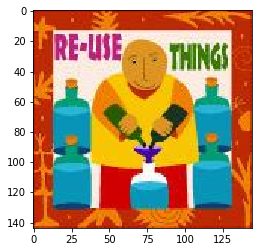

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# %matplotlib inline # Show the plots as a cell within the Jupyter Notebooks
plt.imshow(mpimg.imread(filenames[0]))

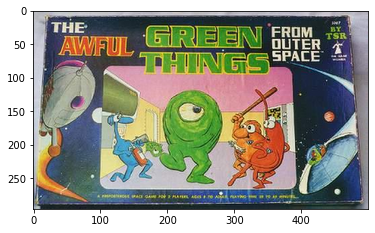

In [6]:
plt.imshow(mpimg.imread(filenames[indices[0][1]]), interpolation='lanczos')

# Bunch of image


In [7]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        # To save the plot in a high definition format i.e. PDF, uncomment the following line:
        #plt.savefig('results/' + str(random.randint(0,10000))+'.pdf', format='pdf', dpi=1000)
        # We will use this line repeatedly in our code.

Number of images =  9144
Number of features per image =  2048


IndexError: list index out of range

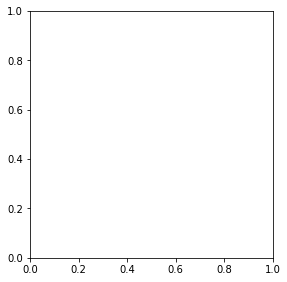

In [8]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)


for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors(
        [feature_list[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

IndexError: list index out of range

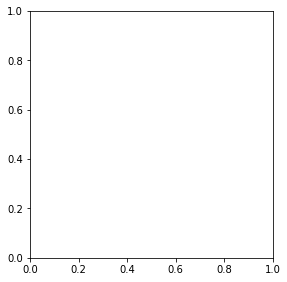